# Классификация агрокультур на основе изменения показателя вегетационных индексов во временной последовательности

Перед участниками чемпионата стоит задача классификации
агрокультур на основе изменения показателя вегетационных индексов во
временной последовательности. Созданная за время чемпионата модель
поможет оптимизировать рабочие процессы в сфере сельского хозяйства,
обеспечить органы власти актуальными и достоверными сведениями,
увеличить социальный, инвестиционный и производственный потенциал
отрасли, а также повысить достоверность и удобство использования
информации о сельскохозяйственных объектах.

Столбцы:

● `id` – идентификатор объекта (поля)  
● `area` – площадь поля в га  
● `nd mean YYYY-MM-DD` – медианное значение вегетационного индекса
NDVI для данного поля на указанную дату  
● `geo` – координаты границ поля  
● `crop` – столбец для предсказания, содержит тип произрастающей
культуры по данным сельхозтоваропроизводителей:
* 0 - подсолнечник
* 1 - картофель
* 2 - пшеница озимая
* 3 - гречиха
* 4 - кукуруза
* 5 - пшеница яровая
* 6 - сахарная свекла


In [ ]:
!pip install catboost --q
!pip install optuna -q

     |████████████████████████████████| 76.6 MB 1.9 MB/s 
     |████████████████████████████████| 348 kB 5.0 MB/s 
     |████████████████████████████████| 209 kB 49.3 MB/s 
     |████████████████████████████████| 81 kB 8.4 MB/s 
     |████████████████████████████████| 78 kB 217 kB/s 
     |████████████████████████████████| 147 kB 48.2 MB/s 
     |████████████████████████████████| 50 kB 2.6 MB/s 
     |████████████████████████████████| 112 kB 41.9 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import catboost
import xgboost as xgb
import optuna
import lightgbm as lgb
import warnings

from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import  train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, make_scorer
from sklearn.pipeline import Pipeline
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_randfloat

warnings.filterwarnings("ignore")

## Знакомство с данными

In [ ]:
df = pd.read_csv("https://lodmedia.hb.bizmrg.com/case_files/883465/train_dataset_train.csv")

In [ ]:
df.head()

,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,nd_mean_2021-05-20,nd_mean_2021-06-04,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,crop
0,3536,20,0.072846,0.261778,0.062981,0.104442,0.021096,0.052202,0.158723,0.000000,...,0.108999,0.118854,0.000000,0.000000,0.026784,0.126832,0.614770,0.008857,0.081498,3
1,3739,45,0.332928,0.287182,0.097138,0.152467,0.075484,0.000000,0.140326,0.163340,...,0.134469,0.208268,0.000000,0.000000,0.111148,0.174914,0.179612,0.113071,0.046997,4
2,1294,28,0.013679,0.007055,0.120804,0.037839,0.259125,0.000000,0.037446,0.506516,...,0.084467,0.000000,0.210496,0.130467,0.155225,0.090607,0.054127,0.007437,0.219614,2
3,2859,19,0.105976,0.052500,0.001917,0.011531,0.042316,0.000000,0.000000,0.043604,...,0.000000,0.642226,0.132886,0.000000,0.570928,0.073492,0.378900,0.327677,0.586523,5
4,3685,33,0.130885,0.063492,0.024416,0.000000,0.150671,0.046717,0.254284,0.101479,...,0.206158,0.099058,0.152003,0.073357,0.147842,0.157676,0.012048,0.054223,0.017539,4


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4830 entries, 0 to 4829
Data columns (total 74 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  4830 non-null   int64  
 1   area                4830 non-null   int64  
 2   nd_mean_2021-04-16  4830 non-null   float64
 3   nd_mean_2021-04-19  4830 non-null   float64
 4   nd_mean_2021-04-22  4830 non-null   float64
 5   nd_mean_2021-04-26  4830 non-null   float64
 6   nd_mean_2021-04-28  4830 non-null   float64
 7   nd_mean_2021-05-02  4830 non-null   float64
 8   nd_mean_2021-05-04  4830 non-null   float64
 9   nd_mean_2021-05-07  4830 non-null   float64
 10  nd_mean_2021-05-16  4830 non-null   float64
 11  nd_mean_2021-05-17  4830 non-null   float64
 12  nd_mean_2021-05-21  4830 non-null   float64
 13  nd_mean_2021-05-26  4830 non-null   float64
 14  nd_mean_2021-05-27  4830 non-null   float64
 15  nd_mean_2021-05-29  4830 non-null   float64
 16  nd_mea

В тренировочных данных 78 столбцов и 4898 строк. Шаг дат в столбцах `nd mean YYYY-MM-DD` разный.

## Анализ данных

In [ ]:
# df.loc[:, df.columns != 'crop'] = df.replace(0,np.nan)
# df.loc[:, ~df.columns.isin(['id', 'area', 'crop', '.geo'])] = df.loc[:, ~df.columns.isin(['id', 'area', 
#                                                                                           'crop', '.geo'])].interpolate(method='linear', 
#                                                                                                                         axis=1, 
#                                                                                                                         limit_direction='both')

Изучим столбец `area`.

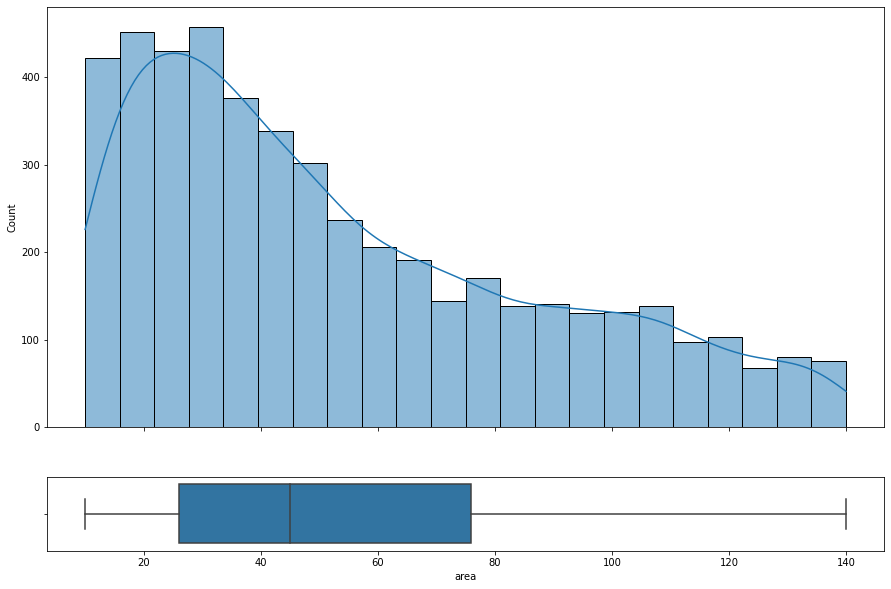

In [ ]:
f, (ax_hist, ax_box) = plt.subplots(2, figsize=(15, 10), sharex=True, gridspec_kw={"height_ratios": (.85, .15)})

sns.histplot(data=df, x="area", kde=True, ax=ax_hist)
sns.boxplot(df['area'], ax=ax_box)

plt.show()

Площадь поля распределена от 10 до 140 га, при этом большинство полей (75%) имеют площадь до 77 га. Посмотрим на площадьв  зависимости от типа культур.


In [ ]:
df.groupby('crop')['area'].agg(['mean', 'sum'])

,mean,sum
crop,,
0,58.318182,42339
1,38.821429,27175
2,53.928264,37588
3,54.618321,35775
4,49.576602,35596
5,56.079341,37461
6,66.463964,44265


Как видим, меньше всего площажи зпнимает культура 1, больше всего - 6, остальные культуры распределены примерно поровну.

Изучим столбец `crop`.

In [ ]:
df['crop'].value_counts(normalize=True)

0    0.150311
4    0.148654
1    0.144928
2    0.144306
5    0.138302
6    0.137888
3    0.135611
Name: crop, dtype: float64

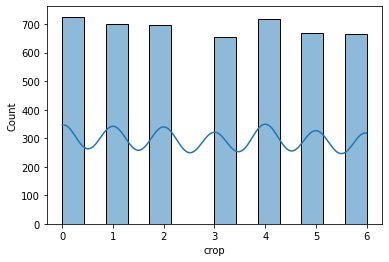

In [ ]:
sns.histplot(data=df, x="crop", kde=True)

Как можем заметить, тип культур в представленных данных сбалансирован.

Изучим столбец `.geo`.

In [ ]:
df['.geo'].head()

0    {"type":"Polygon","coordinates":[[[42.49107269...
1    {"type":"Polygon","coordinates":[[[50.25545110...
2    {"type":"Polygon","coordinates":[[[37.99698998...
3    {"type":"Polygon","coordinates":[[[44.72154181...
4    {"type":"Polygon","coordinates":[[[34.77829934...
Name: .geo, dtype: object

Данный столбец содержит координаты посевных полей. Данные представлены в Plygon, Multipolygon и GeometryCollection. Данные форматы содержат координаты, описывающие периметр поля. Выделим первые координаты широты и долготы в отдельные столбцы.

In [ ]:
df['longitude'] = df['.geo'].str.findall('(\d+\.\d+)').str[0].astype(float)
df['latitude'] = df['.geo'].str.findall('(\d+\.\d+)').str[1].astype(float)

In [ ]:
df.head()

,id,area,nd_mean_2021-04-16,nd_mean_2021-04-19,nd_mean_2021-04-22,nd_mean_2021-04-26,nd_mean_2021-04-28,nd_mean_2021-05-02,nd_mean_2021-05-04,nd_mean_2021-05-07,...,nd_mean_2021-06-05,nd_mean_2021-06-10,nd_mean_2021-07-05,nd_mean_2021-08-13,nd_mean_2021-08-27,nd_mean_2021-05-08,nd_mean_2021-05-24,crop,longitude,latitude
0,3536,20,0.072846,0.261778,0.062981,0.104442,0.021096,0.052202,0.158723,0.000000,...,0.000000,0.000000,0.026784,0.126832,0.614770,0.008857,0.081498,3,42.491073,51.414036
1,3739,45,0.332928,0.287182,0.097138,0.152467,0.075484,0.000000,0.140326,0.163340,...,0.000000,0.000000,0.111148,0.174914,0.179612,0.113071,0.046997,4,50.255451,56.605392
2,1294,28,0.013679,0.007055,0.120804,0.037839,0.259125,0.000000,0.037446,0.506516,...,0.210496,0.130467,0.155225,0.090607,0.054127,0.007437,0.219614,2,37.996990,53.835904
3,2859,19,0.105976,0.052500,0.001917,0.011531,0.042316,0.000000,0.000000,0.043604,...,0.132886,0.000000,0.570928,0.073492,0.378900,0.327677,0.586523,5,44.721542,55.935339
4,3685,33,0.130885,0.063492,0.024416,0.000000,0.150671,0.046717,0.254284,0.101479,...,0.152003,0.073357,0.147842,0.157676,0.012048,0.054223,0.017539,4,34.778299,52.907201


In [ ]:
df.groupby('crop')[['longitude', 'latitude']].mean()

,longitude,latitude
crop,,
0,44.217727,52.304382
1,40.046256,54.016130
2,41.430098,53.099794
3,45.818809,53.701410
4,40.136284,52.607075
5,49.557337,54.779114
6,44.287841,52.945228


Проверим признаки на мультиколлинеарность.

In [ ]:
matrix = df.corr().unstack()
matrix = matrix[abs(matrix) >= 0.6]
matrix = matrix[abs(matrix) != 1]
matrix

nd_mean_2021-06-06  nd_mean_2021-04-20    0.602454
                    nd_mean_2021-05-19    0.665534
                    nd_mean_2021-05-20    0.660957
                    nd_mean_2021-08-27    0.604031
nd_mean_2021-04-20  nd_mean_2021-06-06    0.602454
                    nd_mean_2021-05-19    0.629367
                    nd_mean_2021-05-20    0.637393
nd_mean_2021-05-19  nd_mean_2021-06-06    0.665534
                    nd_mean_2021-04-20    0.629367
                    nd_mean_2021-05-20    0.708838
                    nd_mean_2021-08-27    0.718053
nd_mean_2021-05-20  nd_mean_2021-06-06    0.660957
                    nd_mean_2021-04-20    0.637393
                    nd_mean_2021-05-19    0.708838
                    nd_mean_2021-08-27    0.663753
nd_mean_2021-08-27  nd_mean_2021-06-06    0.604031
                    nd_mean_2021-05-19    0.718053
                    nd_mean_2021-05-20    0.663753
dtype: float64

### Выделение дополнительных признаков

Выделим средний индекс NDVI для каждого месяца

In [ ]:
april = [col for col in df.columns if '2021-04' in col]
may = [col for col in df.columns if '2021-05' in col]
june = [col for col in df.columns if '2021-06' in col]
july = [col for col in df.columns if '2021-07' in col]
august = [col for col in df.columns if '2021-08' in col]


df['april'] = df[april].mean(axis=1)
df['may'] = df[may].mean(axis=1)
df['june'] = df[june].mean(axis=1)
df['july'] = df[july].mean(axis=1)
df['august'] = df[august].mean(axis=1)

In [ ]:
df.groupby('crop')[['april', 'may', 'june', 'july', 'august']].mean()

,april,may,june,july,august
crop,,,,,
0,0.135043,0.211439,0.285099,0.485183,0.223736
1,0.101833,0.173338,0.278212,0.475195,0.274526
2,0.119647,0.215467,0.349603,0.429830,0.143225
3,0.125495,0.207140,0.369562,0.347704,0.261970
4,0.151588,0.170840,0.296640,0.506080,0.239018
5,0.140078,0.259436,0.376604,0.312908,0.229467
6,0.114752,0.198339,0.282813,0.490362,0.257836


## Обучение моделей

Создадим scorer.

In [ ]:
scorer=make_scorer(recall_score, average='macro', zero_division=0)

Создадим функцию для добавления результатов работы моделей.

In [ ]:
results = {'name': [], 'best_params':[], 'Recall':[]}

def add_model_result(results, name, best_params, recall):
    results['name'].append(name)
    results['best_params'].append(best_params)
    results['Recall'].append(recall)

Разделим данные на признаки и целевой признак.

In [ ]:
X = df.drop(['id', 'crop', '.geo'], axis =1)
y = df['crop']

In [ ]:
models = [LogisticRegression(),
          KNeighborsClassifier(), 
          GaussianNB(), 
          SVC(random_state=17), 
          RandomForestClassifier(random_state=42), 
          xgb.XGBClassifier(random_state=42, objective = 'multi:softmax'),
          CatBoostClassifier(random_state=42, loss_function = 'MultiClass', silent=True),
          lgb.LGBMClassifier(random_state=42, objective = 'multiclass')]

scores = []
for n, model in enumerate(models):
    scores.append(cross_val_score(model, X, y, scoring=scorer, cv=5).mean())

names = ['Логистическая регрессия', 'Метод К-ближайших соседей',
         'Байесовский классификатор', 'Метод опорных векторов',
         'RandomForest', 'XGBoost', 'CatBoost', 'LightGBM']

In [ ]:
pd.DataFrame({'Recall': scores}, index=names).sort_values(by='Recall', ascending=False)

,Recall
LightGBM,0.972858
CatBoost,0.968533
RandomForest,0.964298
XGBoost,0.962588
Байесовский классификатор,0.938119
Логистическая регрессия,0.875306
Метод К-ближайших соседей,0.495883
Метод опорных векторов,0.275639


### LightGBM

In [ ]:
pipe_lgb = Pipeline([('scaler', StandardScaler()), ('clf', lgb.LGBMClassifier())])
recall_lgb = (cross_val_score(pipe_lgb, X, y, scoring=scorer, cv=5)).mean()
print('recall = ', recall_lgb)

recall =  0.9733948428320005


In [ ]:
add_model_result(results, 'LightGBM', 'None', recall_lgb)

In [ ]:
def objective(trial):

    param = {
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        'max_depth' : trial.suggest_int('max_depth', -1, 15),
        'n_estimators' : trial.suggest_int('n_estimators', 50, 200),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    model = lgb.LGBMClassifier(**param)
    score = cross_val_score(model, X, y, scoring=scorer, cv=3).mean()
    return score

In [ ]:
%%time
study_lgb = optuna.create_study(direction = "maximize")
study_lgb.optimize(objective, n_trials = 200, timeout=5000)
trial_lgb = study_lgb.best_trial

[I 2022-11-19 17:07:30,635] A new study created in memory with name: no-name-f54cc678-05ea-46b0-b0b8-1bb42c31c056
[I 2022-11-19 17:08:55,293] Trial 0 finished with value: 0.9691671414501508 and parameters: {'num_leaves': 93, 'max_depth': -1, 'n_estimators': 150, 'learning_rate': 0.17075429769322392, 'bagging_fraction': 0.9415462119720704, 'bagging_freq': 5, 'min_data_in_leaf': 7, 'min_child_samples': 83}. Best is trial 0 with value: 0.9691671414501508.
[I 2022-11-19 17:09:17,422] Trial 1 finished with value: 0.9674500205236513 and parameters: {'num_leaves': 20, 'max_depth': 7, 'n_estimators': 117, 'learning_rate': 0.09381078255595653, 'bagging_fraction': 0.9229364985973441, 'bagging_freq': 5, 'min_data_in_leaf': 10, 'min_child_samples': 21}. Best is trial 0 with value: 0.9691671414501508.
[I 2022-11-19 17:10:57,202] Trial 2 finished with value: 0.9634246208472103 and parameters: {'num_leaves': 98, 'max_depth': 15, 'n_estimators': 123, 'learning_rate': 0.029772304629302977, 'bagging_fra

CPU times: user 2h 38min 9s, sys: 1min 3s, total: 2h 39min 12s
Wall time: 1h 23min 34s


In [ ]:
print("Best Score: ", trial_lgb.value)
print("Best Params: ", study_lgb.best_params)

Best Score:  0.9719855284975484
Best Params:  {'num_leaves': 135, 'max_depth': 10, 'n_estimators': 184, 'learning_rate': 0.150746251184781, 'bagging_fraction': 0.6426868701199809, 'bagging_freq': 1, 'min_data_in_leaf': 4, 'min_child_samples': 87}


### CatBoost

In [ ]:
model = CatBoostClassifier(silent = True)
recall_cat = (cross_val_score(model,X, y, scoring=scorer, cv=5)).mean()
print('recall = ', recall_cat)

recall =  0.9677263825996791


In [ ]:
add_model_result(results, 'CatBoost', 'None', recall_cat)

In [ ]:
pipe_cat = Pipeline([('scaler', StandardScaler()), ('clf', CatBoostClassifier(silent = True))])
recall = (cross_val_score(pipe_cat, X, y, scoring=scorer, cv=5)).mean()
print('recall = ', recall)

recall =  0.967501072226181


In [ ]:
def objective(trial):
  
    params = {
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.002, 0.12),
        'iterations': trial.suggest_int('iterations', 500, 1700),
        'random_strength': trial.suggest_int('random_strength', 0, 10),
        'silent' : True
      }

    model = CatBoostClassifier(**params)
    score = cross_val_score(model, X, y, scoring=scorer, cv=3).mean()
    return score

In [ ]:
%%time
study_cat = optuna.create_study(direction = "maximize")
study_cat.optimize(objective, n_trials = 50, timeout=1000)
trial = study_cat.best_trial

[I 2022-11-19 10:18:43,220] A new study created in memory with name: no-name-7c348d2a-ff35-43c4-b3c5-b7e2a278d2eb
[I 2022-11-19 11:05:42,993] Trial 0 finished with value: 0.9642609370779217 and parameters: {'depth': 9, 'l2_leaf_reg': 5, 'learning_rate': 0.032302126867768226, 'iterations': 1231, 'random_strength': 4}. Best is trial 0 with value: 0.9642609370779217.


CPU times: user 1h 29min 20s, sys: 7.38 s, total: 1h 29min 28s
Wall time: 46min 59s


In [ ]:
print("Best Score: ", trial.value)
print("Best Params: ", study_cat.best_params)

Best Score:  0.9642609370779217
Best Params:  {'depth': 9, 'l2_leaf_reg': 5, 'learning_rate': 0.032302126867768226, 'iterations': 1231, 'random_strength': 4}


In [ ]:
add_model_result(results, 'CatBoost_optuna', study_cat.best_params, trial.value)

### Ансамбль

In [ ]:
clf_one = CatBoostClassifier(silent=True)
clf_two = lgb.LGBMClassifier()
clf_three = xgb.XGBClassifier()
clf_four = RandomForestClassifier(random_state=42)

estimators = [
    ('cat', clf_one),
    ('lgb', clf_two),
    ('xgb', clf_three),
    ('rf', clf_four)
]

In [ ]:
clf = VotingClassifier(estimators, voting='soft')
recall_vc = (cross_val_score(clf,X, y, scoring=scorer, cv=5)).mean()
print('recall = ', recall_vc)

recall =  0.9701492855806407


In [ ]:
add_model_result(results, 'VotingClassifier', estimators, recall_vc)

### Stacking

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
clf = StackingClassifier(estimators=estimators, 
                         final_estimator=LogisticRegression(),
                         stack_method='auto',
                         n_jobs=-1,
                         passthrough=False)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
recall_sc = recall_score(y_test, pred, average='macro', zero_division=0)
print('recall = ', recall_sc)

recall =  0.9682500828889139


In [ ]:
add_model_result(results, 'StackingClassifier', estimators, recall_sc)


### Результаты

In [ ]:
pd.DataFrame(results).sort_values('Recall', ascending=False)

,name,best_params,Recall
0,LightGBM,None,0.973395
3,VotingClassifier,"[(cat, <catboost.core.CatBoostClassifier objec...",0.970149
4,StackingClassifier,"[(cat, <catboost.core.CatBoostClassifier objec...",0.968250
1,CatBoost,None,0.967726
2,CatBoost_optuna,"{'depth': 9, 'l2_leaf_reg': 5, 'learning_rate'...",0.964261


Лучшей моделью стала LightGBM на стандартизированных признаках и дефолтных параметрах.

## Тест

In [ ]:
test = pd.read_csv('https://lodmedia.hb.bizmrg.com/case_files/883465/test_dataset_test.csv')
solution = pd.read_csv('/content/sample_solution.csv')

In [ ]:
test['longitude'] = test['.geo'].str.findall('(\d+\.\d+)').str[0].astype(float)
test['latitude'] = test['.geo'].str.findall('(\d+\.\d+)').str[1].astype(float)

test['april'] = test[april].mean(axis=1)
test['may'] = test[may].mean(axis=1)
test['june'] = test[june].mean(axis=1)
test['july'] = test[july].mean(axis=1)
test['august'] = test[august].mean(axis=1)

In [ ]:
X_test = test.drop(['id', '.geo'], axis=1)

In [ ]:
pipe.fit(X,y)
solution['crop'] = pipe.predict(X_test)

In [ ]:
solution.to_csv('solution_lgb_pipe.csv', index=False) 

## Вывод

В ходе исследования было добавлены новые признаки: широта и долгота, а также средние значения NDVI за каждый представленный месяц. 

В результате лучшая модель - LightGBM на дефолтных параметрах и стандартизированных признаках, которая показала значение метрики Recall 0.9734 на кросс-валидации.